### GP Regression with Kalman Filtering and Online Hyper-parameter optimization

#### Fit a matern GP $\nu = 3/2$

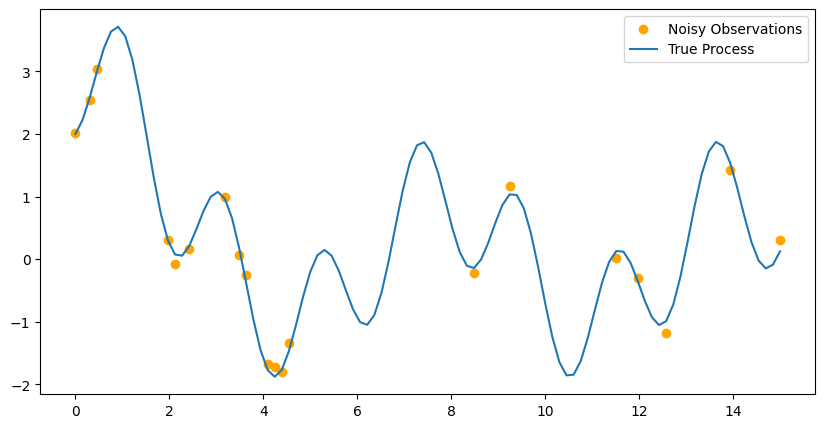

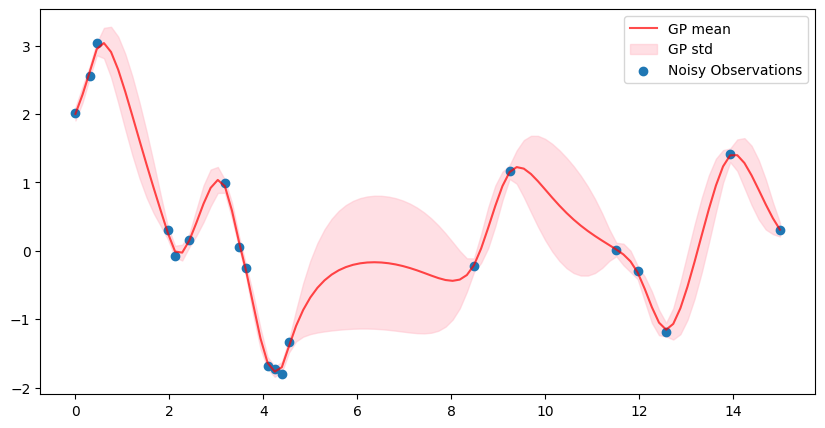

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy

np.random.seed(2)
n_steps = 100
dt = 0.15
time = np.linspace(0, n_steps*dt, n_steps)

N = 20 # number of random points
M = 100 # number of test points

sigma_2 = 0.1 ** 2

def process(t, sigma_2):
    noise = np.random.normal(0, np.sqrt(sigma_2), size=t.shape)
    y = np.sin(t) + 2*np.exp(-t**2/2) + np.exp(-t**3/2) - np.cos(3*t)
    return y+noise

y = np.sin(time) + 2*np.exp(-time**2/2) + np.exp(-time**3/2) - np.cos(3*time)

to = np.random.choice(time, size = N, replace = False).reshape(-1,1)
to = np.sort(to)
yo = process(to, sigma_2)

# test points
t_test = np.linspace(0, n_steps*dt, M).reshape(-1,1)
tot2 = np.vstack([to, t_test])

plt.figure(figsize = (10,5))
plt.scatter(to, yo, label = 'Noisy Observations', color = 'orange')
plt.plot(time, y, label = 'True Process')
plt.legend()
plt.show()


def matern32_kernel(X, Y, lengthscale=1.0, variance=1.0):

    distance = np.abs(X - Y.T)
    
    # Calculate the kernel matrix
    sqrt3 = np.sqrt(3.0)
    K = variance * (1.0 + sqrt3 * distance / lengthscale) * np.exp(-sqrt3 * distance / lengthscale)
    
    return K


def gp_regression(X1, X2, y1, kernel, noise = None):

    K11 = kernel(X1, X1)
    if noise is None:
        K11 += np.eye(K11.shape[0]) * 0.1**2
    K12 = kernel(X1, X2)
    K22 = kernel(X2, X2)


    L = scipy.linalg.cholesky(K11, lower = True)
    E = scipy.linalg.solve_triangular(L, K12, lower = True)
    v = scipy.linalg.solve_triangular(L, y1, lower = True)

    μ = E.T @ v
    Σ = K22 - E.T @ E

    return μ, Σ

mu, var = gp_regression(X1 = to, X2 = t_test, y1 = yo, kernel = matern32_kernel)

mu_gp = mu.flatten()
var_gp = np.diag(var).flatten()

plt.figure(figsize = (10,5))
plt.plot(t_test, mu_gp, 'r-', label = 'GP mean', alpha = 0.7)
plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'pink', alpha = 0.5, label = 'GP std')
plt.scatter(to, yo, label = 'Noisy Observations')
#plt.scatter(t_test, process(t_test, sigma_2), color = 'red')
plt.legend()
plt.show()


In [5]:
t_test.shape

(100, 1)

#### Kalman Filter and Smoothing 

In [45]:
# Just merging observation time with test times 
# and sorting them to get the total time stamps TT
total_time = np.vstack([to, t_test])
indices = np.argsort(total_time.flatten(), axis = -1)
total_time = total_time[indices]
TT = total_time.shape[0]

In [46]:
# Define the LTI SDE model: Matern 3/2
ell = 1.0
lambda_ = np.sqrt(3) / ell
mag_sigma_2 = 1.0**2       # Magnitude of state covariance, can also tune this 
sigma_2 = 0.1 ** 2      # Observation noise

F = np.array([[0, 1], [-lambda_**2, -2 * lambda_]])
L = np.array([0, 1]).reshape(2,1)
Q = 4 * lambda_**3 * mag_sigma_2     # Process Noise
H = np.array([1, 0]).reshape(1,2)
Pinf = mag_sigma_2 * np.diag([1, lambda_**2])  # State Covariance


# Initialize
m = np.zeros((F.shape[0], 1))
P = copy.deepcopy(Pinf)

# Plae holders
MF = np.zeros((F.shape[0], TT))                # Predicted Filter Mean
PF = np.zeros((F.shape[0], F.shape[1], TT))    # Predictd Filter Covariance
MP = np.zeros((F.shape[0], TT))                # Updated Filter Mean
PP = np.zeros((F.shape[0], F.shape[1], TT))    # Updated Filter Covariance
GS = np.zeros((F.shape[0], F.shape[1], TT))    # Smoother Gain

doupdate = indices < N         # Perform state update on test points

for k in range(0, TT):
    if k == 0:
        dt = 0
    else:
        dt = total_time[k] - total_time[k-1]
    
    # Solve the LTI Stochastic Differential Equation
    A = scipy.linalg.expm(F * dt)
    Q = Pinf - A @ Pinf @ A.T

    # kalman prediciton
    mp = A @ m
    Pp = A @ P @ A.T + Q

    # Pre-calculate smoother gain
    # Gs = (P @ A.T) @ np.linalg.inv(Pp)
    Gs = np.linalg.lstsq(Pp.T, (P @ A.T).T, rcond = None)[0].T

    # Kalman Update
    if doupdate[k]:
        v = (yo[indices[k]] - H @ m).astype(np.float32)
        S = H @ P @ H.T + sigma_2
        #K = (Pp @ H.T)/S
        K = np.linalg.lstsq(S.T, (P @ H.T).T, rcond = None)[0].T
        m += K * v
        P -= K @ H @ P
    else:
        m = mp
        P = Pp

    MF[:, k] = m.T
    PF[:, :, k] = P
    MP[:, k] = mp.T
    PP[:, :, k] = Pp
    GS[:, :, k] = Gs

# Run RTS smoother
MS = copy.deepcopy(MF)
PS = copy.deepcopy(PF)
ms = MS[:, -1]
Ps = PS[:,:,-1]

for j in range(TT-2, -1, -1):
    ms = MF[:, j] + GS[:, :, j+1] @ (ms - MP[:, j+1])
    Ps = PF[:,:,j] + GS[:,:,j+1] @ (Ps - PP[:,:,j+1]) @ (GS[:,:,j+1]).T
    MS[:,j] = ms
    PS[:,:,j] = Ps


# Extract Values
def get_var_f(index):
    var_f_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_f_.append( H @ PF[:,:,j] @ H.T )
    return np.array(var_f_)

def get_var_smooth(index):
    var_s_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_s_.append( H @ PS[:,:,j] @ H.T )
    return np.array(var_s_)

m_f = (H @ MF).T    # filter mean
m_s = (H @ MS).T    # smoother mean

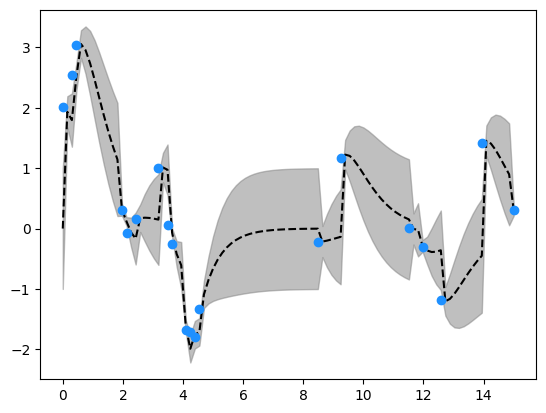

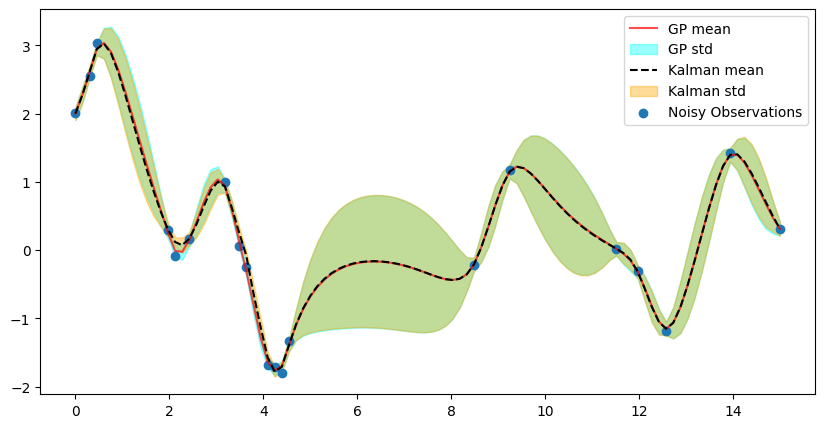

In [47]:
ii = [indices > N-1][0]
m_f = m_f[ii].flatten()
m_s = m_s[ii].flatten()
var_f = get_var_f(ii).flatten()
var_s = get_var_smooth(ii).flatten()

plt.plot(t_test, m_f, 'k--')
plt.plot(to, yo, 'o', color='dodgerblue')
plt.fill_between(t_test.flatten(), m_f-np.sqrt(var_f), \
                 m_f+np.sqrt(var_f), color='gray', alpha=0.5)

plt.show()


plt.figure(figsize = (10,5))
plt.plot(t_test, mu_gp, 'r-', label = 'GP mean', alpha = 0.7)
plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'aqua', alpha = 0.4, label = 'GP std')

plt.plot(t_test, m_s, 'k--', label = 'Kalman mean')
plt.fill_between(t_test.flatten(), m_s + np.sqrt(var_s), m_s - np.sqrt(var_s), color = 'orange', alpha = 0.4, label = 'Kalman std')
plt.scatter(to, yo, label = 'Noisy Observations')
plt.legend()
plt.show()

### MCMC - Metropolis Hasting (Online Hyperparameter optimization)

In [48]:
def metropolis_hasting(target_density, proposal_density, proposal_sampler, num_samples, initial_state, x, L, Q, burn_in):
    samples = []
    num_accepted = 0

    current_state = initial_state

    for i in range(num_samples + burn_in):
        proposed_state = proposal_sampler(current_state)
        hasting_ratio = proposal_density(current_state, proposed_state) / proposal_density(proposed_state, current_state)
        metropolis_ratio = target_density(proposed_state, x, L, Q) / target_density(current_state, x, L, Q)
        ratio = metropolis_ratio * hasting_ratio

        acceptance_prob = min(ratio, 1)

        if np.random.rand() < acceptance_prob:
            current_state = proposed_state
            num_accepted += 1

        if i >= burn_in:
            samples.append(current_state)

    acceptance_rate = num_accepted / (num_samples + burn_in)
    print(f'Acceptance rate: {acceptance_rate}')
    return samples


def lognormal(proposed_state, current_state, sigma=0.1):
    # Proposal Density
    log_ratio_ell = np.log(proposed_state[0]) - np.log(current_state[0])            # corresponds to (ln(x) - \mu)
    log_ratio_sigma_sq = np.log(proposed_state[1]) - np.log(current_state[1])
    
    prob_ell = (1 / (proposed_state[0] * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(-log_ratio_ell ** 2 / (2 * sigma ** 2))
    prob_sigma_sq = (1 / (proposed_state[1] * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(-log_ratio_sigma_sq ** 2 / (2 * sigma ** 2))
    
    return prob_ell * prob_sigma_sq

def proposal_sampler(current_state, sigma=0.1):
    # Samples from lognormal distribution
    proposed_ell = np.random.lognormal(mean=np.log(current_state[0]), sigma=sigma)
    proposed_sigma_sq = np.random.lognormal(mean=np.log(current_state[1]), sigma=sigma)
    
    return np.array([proposed_ell, proposed_sigma_sq])

In [49]:
from scipy.linalg import expm, det, inv
from scipy.integrate import quad


# Function to update F, Q and P based on the hyper-parameters
def update_F_Q_P(ell, sigma_sq):
    F = np.array([[0, 1], [-3/(ell**2), -2*np.sqrt(3)/ell]])
    Q = 4 * np.sqrt(27) * sigma_sq / (ell**3)
    P = sigma_sq * np.diag([1, 3/ell**2])
    return F, Q, P


# Evaluate negative log-likelihood
def nll(params, x, L, Q):
    #Need the states not the observations.
    ell, sigma_sq = params
    F, Q, P = update_F_Q_P(ell, sigma_sq)

    nll = 0
    for k in range(len(x)-1):
        A_k = expm(F * dt)
        delta_xk = x[k+1] - np.dot(A_k, x[k])

        def integrand(tau, i, j):
            exp1 = expm(F * (dt - tau))
            exp2 = expm(F.T * (dt - tau))
            variance = L.reshape(-1,1) @ Q.reshape(-1,1) @ (L.reshape(-1,1)).T
            return (exp1 @ variance @ exp2)[i, j]

        Sigma_k = np.zeros_like(F)
        for n in range(F.shape[0]):
            for m in range(F.shape[1]):
                Sigma_k[n,m], _ = quad(integrand, 0, dt, args = (n, m))
        
        #Cholesky
        Lo = np.linalg.cholesky(Sigma_k) + 1e-12
        a = np.linalg.solve(Lo.T, np.linalg.solve(Lo,delta_xk))      # a = Sigma_k_inv @ delta_xk
    
        nll += 0.5 * np.log(det(2 * np.pi * Sigma_k))
        nll += 0.5 * delta_xk.T @ a

    return nll